### Thin Zoonomia dataset

Import modules

In [32]:
from ete3 import Tree
import toytree
import toyplot
import toyplot.pdf
import itertools
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

Functions

In [30]:
def distance_within_order(df, current_sp, nwkete):
    '''Returns distance to other individuals in super order'''
    distance_pi_het = pd.DataFrame([[r.Species, nwkete.get_distance(current_sp, r.Species), r.Heterozygosity, r.Pi] for i,r in df.iterrows() if r.Species!=current_sp])
    distance_pi_het.columns = ["Species", "distance", "Heterozygosity", "Pi"]
    distance_pi_het = distance_pi_het.sort_values(by="distance")
    distance_pi_het.index = range(len(distance_pi_het))
    return distance_pi_het

def choose_pi_over_het(df):
    ''' Chooses the "best" pi/het value for species lacking them. 
    Pi (Buffalo) is taken over Heterzygosity (Zoonomia)'''
    pi = np.nan
    for i,r in df.iterrows():
        if not math.isnan(r.Pi):
            pi = r.Pi
            return pi
        if not math.isnan(r.Heterozygosity):
            pi = r.Heterozygosity
            return pi
    return pi

def prune_species(d, tree):
    '''Returns species ranking higher in decision tree'''
    for param, criteria in tree.items():
        if criteria!="Max" and criteria!="Min":
            subd = d[d[param]!=criteria]
            if len(subd)==1:
                return subd.Species.values[0]
        else:
            if len(d[param].unique())==1:
                continue
            sorted_d = d.sort_values(by=param, ascending=False if criteria!="Max" else True)
            sorted_d.index = range(len(sorted_d))
            return sorted_d.Species.values[0]

Read data

In [33]:
# Read metadata 
meta = pd.read_csv("./../data/zoonomia_assembly_metadata.csv")

# Read phylogenies
nwkete = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)

# Read DNM counts
dnms = pd.read_csv("./../data/dnm_est.tsv",sep="\t")[["Species", "Mat DNMs", "Pat DNMs"]]
dnms["Species"] = [sp.split("(")[0].rstrip().replace(" ","_") for sp in dnms.Species]
dnms["Total_dnms"] = dnms["Mat DNMs"] + dnms["Pat DNMs"]
dnm_counts = {k:v for k,v in zip(dnms["Species"], dnms["Total_dnms"])}

# Tree of sex
treeofsex = pd.read_csv("./../data/tree_of_sex.csv")
column = 'Karyotype (ZO,ZW,XY,XO,WO,homomorphic,complex XY,complex ZW)'
complex_XY = treeofsex[(treeofsex["Higher taxonomic group"]=="Mammalia") & (treeofsex[column]!="XY")]
genus_complex_XY = [sp.split()[0] for sp in complex_XY["Species"] if "Mus" not in sp]
species_complex_XY = meta[meta.Genus.isin(genus_complex_XY)]["Species"].values
meta = meta[~meta.Genus.isin(genus_complex_XY)].reset_index()

# Pi from Vince Buffalo's paper
buffalo = pd.read_csv("./../data/buffalo_variation.tsv",sep="\t")
buffalo["FullSpecies"] = ["_".join(sp.split()) for sp in buffalo["species"]]
buffalo["Pi"] = [10**d for d in buffalo["log10_diversity"]]

# Add DNM counts to metadata
meta["dnm"] = [dnm_counts[sp] if sp in dnm_counts else 0 for sp in meta.Species]
meta["Anage_ntraits"] = [0 if math.isnan(n_traits) else n_traits for n_traits in meta.AnAge_ntraits]
males = list(meta[meta.Sex=="male"].Species.values)

# Add Buffalo's Pi to metadata
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
meta = meta.set_index("Species").join(buffalo[["FullSpecies", "Pi"]].set_index("FullSpecies")).reset_index()
pi_per_genus = buffalo.groupby("genus").apply(lambda x: np.nanmean(x["Pi"])).to_dict()
fill_genus_pi = []
for i,r in meta.iterrows():
    if math.isnan(r.Pi):
        if r.Genus in pi_per_genus:
            fill_genus_pi.append(pi_per_genus[r.Genus])
        else:
            fill_genus_pi.append(np.nan)
    else:
        fill_genus_pi.append(r.Pi)

# Propagate pi if not available from any source
close_pi = []
for i,r in meta.iterrows():
    if math.isnan(r["Pi"]) and math.isnan(r["Heterozygosity"]):
        subd = meta[meta.SuperOrder==r.SuperOrder]
        current_sp = r.Species
        distance_df = distance_within_order(subd, current_sp, nwkete)
        best_pi = choose_pi_over_het(distance_df)
        close_pi.append(best_pi)
    else:
        close_pi.append(np.nanmean([r.Pi, r.Heterozygosity]))
meta["Pi_het"] = close_pi  

Decision tree to keep species if sequence divergence is below limit (15pi or 2% sequence divergence)

In [34]:
decision_tree = {"dnm":"Max",
                 "AssemblyStatus":"Chromosome",
                 "Sex":"female",
                 "ScaffoldN50":"Max",
                 "AnAge_ntraits":"Max",
                }

In [21]:
#nwkete = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)

Prune species

In [22]:
pi_modifier = 15
pi_data = {r["Species"]:r["Pi_het"] for i,r in meta.iterrows()}
species_out = []

# Iterate over all superorders
for superorder,df in meta.groupby("SuperOrder"):
    
    # Read best tree of order
    nwkete = Tree(order_trees[order_trees.order==superorder]["tree"].values[0])
    
    # Automatically exclude male-based assemblies
    species_out = species_out + list(df[df.Sex=="male"].Species.values)
    subd = df[df.Sex!="male"]
    
    #And dolphin out
    if superorder=="Artiodactyla":
        species_out.append("Tursiops_truncatus")
        subd = subd[subd.Species!="Tursiops_truncatus"]
    
    # Iterate over pairwise species comparisons
    for c in itertools.combinations(subd.Species, r=2):
        sp1, sp2 = c
        seqdiv = nwkete.get_distance(sp1, sp2)
        limit = np.max([pi_data[sp1], pi_data[sp2]])*pi_modifier
        limit = 0.02 if limit<=0.02 else limit # LIMIT OF 2%!
        
        # If sequence divergence is not enough
        if seqdiv <= limit:
            pair_df = subd[subd.Species.isin(c)]
            worst_species = prune_species(pair_df, decision_tree)
            if worst_species not in species_out:
                species_out.append(worst_species)

In [23]:
nwk = toytree.tree("./../trees/241-mammalian-2020v2.phast-242.nh", tree_format=1)
colors_tips = ["coral" if sp in males else "skyblue" if sp in species_complex_XY else "black" if sp not in species_out else "lightgray" for sp in nwk.get_tip_labels()]
#colors_tips = ["skyblue" if sp in species_complex_XY else "black" if sp not in species_out else "lightgray" for sp in nwk.get_tip_labels()]
canvas, axes, mark = nwk.draw(
    tip_labels_align=True,
    tip_labels_colors=colors_tips,
    height=1500,
    tip_labels_style={
        "font-size": "8px",
    }
);
#toyplot.pdf.render(canvas, "pdfs/min0.02_{}pi.pdf".format(pi_modifier))

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="390.0px" height="1500.0px" viewBox="0 0 390.0 1500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t35621fddb82741ba98c751950ca740ba"> Capra_aegagrus Capra_hircus Hemitragus_hylocrius Ammotragus_lervia Ovis_canadensis Ovis_aries Beatragus_hunteri Saiga_tatarica Pantholops_hodgsonii Bos_indicus Bos_taurus Bos_mutus Bison_bison Bubalus_bubalis Moschus_moschiferus Giraffa_tippelskirchi Okapia_johnstoni Antilocapra_americana Rangifer_tarandus Odocoileus_virginianus Elaphurus_davidianus Tragulus_javanicus Monodon_monoceros Delphinapterus_leucas Phocoena_phocoena Neophocaena_asiaeorientalis Orcinus_orca Tursiops_truncatus Lipotes_vexillifer Inia_geoffrensis Ziphius_cavirostris Mesoplodon_bidens Platanista_gangetica Kogia_breviceps Balaenoptera_acutorostrata Balaenoptera_bonaerensis Eschrichtius_robustus Eubalaena_japonica Hippopotamus_amphibius Sus_scrofa Catagonus_wagneri Camelus_bactrianus Camelus_ferus Camelus_dromedarius Vicugna_pacos Enhydra_lutris Pteronura_brasiliensis Mustela_putorius Mellivora_capensis Ailurus_fulgens Spilogale_gracilis Mirounga_angustirostris Leptonychotes_weddellii Neomonachus_schauinslandi Odobenus_rosmarus Zalophus_californianus Ursus_maritimus Ailuropoda_melanoleuca Canis_lupus_familiaris Canis_lupus Lycaon_pictus Vulpes_lagopus Felis_nigripes Felis_catus Puma_concolor Acinonyx_jubatus Panthera_onca Panthera_pardus Panthera_tigris Suricata_suricatta Mungos_mungo Helogale_parvula Cryptoprocta_ferox Hyaena_hyaena Paradoxurus_hermaphroditus Manis_pentadactyla Manis_javanica Ceratotherium_simum_cottoni Ceratotherium_simum Diceros_bicornis Dicerorhinus_sumatrensis Tapirus_terrestris Tapirus_indicus Equus_przewalskii Equus_caballus Equus_asinus Myotis_lucifugus Myotis_brandtii Myotis_myotis Myotis_davidii Murina_feae Eptesicus_fuscus Pipistrellus_pipistrellus Lasiurus_borealis Miniopterus_schreibersii Miniopterus_natalensis Tadarida_brasiliensis Artibeus_jamaicensis Carollia_perspicillata Anoura_caudifer Micronycteris_hirsuta Tonatia_saurophila Desmodus_rotundus Mormoops_blainvillei Pteronotus_parnellii Noctilio_leporinus Pteropus_alecto Pteropus_vampyrus Rousettus_aegyptiacus Eidolon_helvum Macroglossus_sobrinus Hipposideros_galeritus Hipposideros_armiger Rhinolophus_sinicus Craseonycteris_thonglongyai Megaderma_lyra Scalopus_aquaticus Condylura_cristata Uropsilus_gracilis Sorex_araneus Crocidura_indochinensis Erinaceus_europaeus Solenodon_paradoxus Ellobius_lutescens Ellobius_talpinus Ondatra_zibethicus Microtus_ochrogaster Cricetulus_griseus Mesocricetus_auratus Sigmodon_hispidus Onychomys_torridus Peromyscus_maniculatus Mus_spretus Mus_musculus Mus_caroli Mus_pahari Rattus_norvegicus Psammomys_obesus Meriones_unguiculatus Acomys_cahirinus Cricetomys_gambianus Nannospalax_galili Allactaga_bullata Jaculus_jaculus Zapus_hudsonius Dipodomys_ordii Dipodomys_stephensi Perognathus_longimembris Castor_canadensis Marmota_marmota Ictidomys_tridecemlineatus Spermophilus_dauricus Xerus_inauris Aplodontia_rufa Graphiurus_murinus Glis_glis Muscardinus_avellanarius Cavia_porcellus Cavia_tschudii Cavia_aperea Hydrochoerus_hydrochaeris Dolichotis_patagonum Dasyprocta_punctata Cuniculus_paca Capromys_pilorides Myocastor_coypus Ctenomys_sociabilis Octodon_degus Dinomys_branickii Chinchilla_lanigera Fukomys_damarensis Heterocephalus_glaber Thryonomys_swinderianus Petromus_typicus Hystrix_cristata Ctenodactylus_gundi Lepus_americanus Oryctolagus_cuniculus Ochotona_princeps Macaca_fascicularis Macaca_mulatta Macaca_nemestrina Cercocebus_atys Mandrillus_leucophaeus Papio_anubis Chlorocebus_sabaeus Erythrocebus_patas Cerc

In [8]:
colors = toyplot.color.brewer.palette("Paired")
order2colors = {o:colors[i] for i,o in enumerate(meta.SuperOrder.unique())}

New column showing if included in thinned set or not

In [9]:
discard = list(species_complex_XY) + males + species_out #+ ["Ochotona_princeps","Oryctolagus_cuniculus"]
include = [sp for sp in nwk.get_tip_labels() if sp not in discard]
meta["Included"] = [1 if sp in include else 0 for sp in meta.Species]

Species to common names conversion & write to file

In [10]:
species_to_commonnames = meta[["Species", "Organism"]].set_index("Species").to_dict()["Organism"]
species_to_commonnames = {k:v.split("(")[1].replace(")","").capitalize() for k,v in species_to_commonnames.items()}

exceptions = {"Tursiops_truncatus":"Bottlenose dolphin",
              "Beatragus_hunteri":"Hirola",
              "Pere david's deer":"Pere David's deer",
              'Giraffa_tippelskirchi':"Giraffe",
              "Macroglossus_sobrinus":"Long-tongued fruit bat",
              "Equus_asinus":"Donkey",
              "Micronycteris_hirsuta":"Hairy big-eared bat"
             }

meta["Common_names"] = [species_to_commonnames[sp] if sp not in exceptions else exceptions[sp] for sp in meta.Species]
#meta[[c for c in meta.columns if c!="Common_name"]].to_csv("Complete_assembly_metadata_included-binary_morethinned.csv", sep=",")

For the controlled-thinned set, remove species that are far away from a chromosome-level assembly

In [27]:
nwkete = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
keep_species = []
subd = meta[(meta.Included==1) & (meta.ScaffoldN50>350e3)]# | (meta.AssemblyStatus=="Chromosome"))]
div_limit = 0.18

for i,r in subd.iterrows():
    if r.AssemblyStatus=="Chromosome":
        keep_species.append(r.Species)
    else:
        distances = subd[(subd.Species!=r.Species) & (subd.AssemblyStatus=="Chromosome")].apply(lambda r2: nwkete.get_distance(r.Species, r2.Species), axis=1)
        if min(distances)<=div_limit:
            keep_species.append(r.Species)

## Remove bubalis
keep_species = [sp for sp in keep_species if "Bubalus" not in sp]
#keep_species += ["Balaenoptera_bonaerensis","Hippopotamus_amphibius","Delphinapterus_leucas"]

#tree = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
#tree.prune(keep_species, preserve_branch_length=True)
#with open("./../species_list/Final.txt","w") as of:
#    of.write(",".join(keep_species) + "\n")
#tree.write(outfile="./../trees/Final.nwk",format=5)

In [30]:
meta[meta.Species.isin(keep_species)][["Species","ScaffoldN50"]]

,Species,ScaffoldN50
29,Bos_taurus,6806220
30,Sus_scrofa,576008
41,Ovis_aries,100009711
92,Saimiri_boliviensis,18744880
94,Microcebus_murinus,108171978
101,Callithrix_jacchus,129239660
103,Daubentonia_madagascariensis,379919
108,Pongo_abelii,98475126
109,Homo_sapiens,67794873
113,Nomascus_leucogenys,52956880


Add outgroups

In [3]:
#tree = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
#tree.prune(["Hippopotamus_amphibius","Orcinus_orca","Balaenoptera_bonaerensis","Delphinapterus_leucas","Bos_taurus","Sus_scrofa","Capra_aegagrus","Camelus_bactrianus"], preserve_branch_length=True)
#tree.write(outfile="./../trees/Artiodactyla_ultrathinned.nwk",format=5)

In [20]:
chrom_level = meta[(meta.Included==1) & (meta.ScaffoldN50>500e3)]
subd = meta[meta.Species.isin(keep_species)]
irabbit = subd[subd.Species=="Oryctolagus_cuniculus"].index[0]
subd.at[irabbit, "SuperOrder"] = "Castormyomorpha"

for order, df in subd.groupby("SuperOrder"):
    closer_clevel = {}
    for clevel in chrom_level[~chrom_level.Species.isin(df.Species)].Species:
        distances = df.apply(lambda row: nwkete.get_distance(row.Species, clevel), axis=1)
        closer_clevel[clevel] = max(distances)
    closer_clevel = {k:v for k,v in closer_clevel.items() if k not in ["Lipotes_vexillifer",'Tursiops_truncatus']}
    ref = min(closer_clevel, key=closer_clevel.get)
    order_species = list(df.Species.values)
    
    # Lagomorpha and Castor, set manually or not outgroup
    if order=="Castormyomorpha":
        order_species.append("Ochotona_princeps")
    elif order=="Ferae":
        order_species.append("Manis_javanica")
    elif order=="Perissodactyla":
        order_species.append("Felis_catus")
    else:
        order_species.append(ref)
    
    tree = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
    tree.prune(order_species, preserve_branch_length=True)
    with open("./../species_list/{}_ultrathinned.txt".format(order),"w") as of:
        of.write(",".join(order_species) + "\n")
    tree.write(outfile="./../trees/{}_ultrathinned.nwk".format(order),format=5)

Output selected species

In [21]:
for order,df in meta.groupby("SuperOrder"):

    species = list(df[df.Included==1].Species)
    
    #Exceptions where ref sequence (or outgroup) has to be included as well
    if order=="Perissodactyla":
        species.append("Felis_catus")
        
    if order in ['Atlantogenata','Chiroptera','Eulipotyphla']:
        species.append("Homo_sapiens")
        
    if order in ["Lagomorpha","Hystricomorpha","Sciuromorpha"]:
        species.append("Mus_musculus")
        
    nwkete = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
    nwkete.prune(species, preserve_branch_length=True)
    with open("./../species_list/{}_morethinned.txt".format(order),"w") as of:
        of.write(",".join(species) + "\n")
    nwkete.write(outfile="./../trees/{}_morethinned.nwk".format(order),format=5)

Also do the controls

In [41]:
for c in ["Control1", "Control2"]:
    nwkete = Tree("./../trees/241-mammalian-2020v2.phast-242.nh", format=1)
    with open("./../species_list/{}.txt".format(c),"r") as ci:
        species = [line.strip().split(",") for line in ci][0]
    #species = [sp for sp in species if "Aotus" not in sp]
    with open("./../species_list/{}_thinned.txt".format(c),"w") as co:
        co.write(",".join(species) + "\n")
    nwkete.prune(species, preserve_branch_length=True)
    nwkete.write(outfile="./../trees/{}_thinned.nwk".format(c),format=5)
control_species = species

Write all thinned set to file

In [40]:
final_thinned_set = list(set(list(meta[meta.Included==1].Species) + control_species))
with open("./../species_list/All_thinned.txt", "w") as fh:
    fh.write(",".join(final_thinned_set))

### OLD COMMANDS

In [2]:
meta = pd.read_csv("rates_metadata.csv")

In [4]:
gl = pd.read_excel("Generation Lenght for Mammals.xlsx")

In [33]:
gl.to_csv("Generation_Length_for_Mammals.csv")

In [5]:
gl.head()

,TaxID,Order,Family,Genus,Scientific_name,AdultBodyMass_g,Sources_AdultBodyMass,Max_longevity_d,Sources_Max_longevity,Rspan_d,AFR_d,Data_AFR,Calculated_GL_d,GenerationLength_d,Sources_GL
0,7580,Rodentia,Cricetidae,Eligmodontia,Eligmodontia typus,17.37,PanTHERIA,292,PanTHERIA,254.64,73.74,calculated,147.5856,147.585600,Rspan-AFR(SM+Gest)
1,42632,Rodentia,Cricetidae,Microtus,Microtus oregoni,20.35,PanTHERIA,456.25,PanTHERIA,445.85,58.06,calculated,187.3565,187.356500,Rspan-AFR(SM+Gest)
2,42653,Rodentia,Cricetidae,Peromyscus,Peromyscus gossypinus,27.68,PanTHERIA,471.45833335,PanTHERIA,444.87833335,72.58,calculated,201.59471667,201.594717,Rspan-AFR(SM+Gest)
3,42662,Macroscelidea,Macroscelididae,Elephantulus,Elephantulus myurus,59.51,PanTHERIA,401.5,PanTHERIA,412.34,90.48,calculated,210.0586,210.058600,Rspan-AFR(SM+Gest)
4,16652,Rodentia,Cricetidae,Peromyscus,Peromyscus boylii,23.90,PanTHERIA,547.5,PanTHERIA,514.13,79.97,calculated,229.0677,229.067700,Rspan-AFR(SM+Gest)


In [6]:
gl["Species"] = ["_".join(sp.split()) for sp in gl["Scientific_name"]]

In [23]:
meta = meta.set_index("Species").join(gl.set_index("Species"),lsuffix="gl").reset_index()

In [25]:
meta.columns

Index(['Species', 'Unnamed: 0', 'Unnamed: 0.1', 'Ordergl', 'Genusgl',
       'SuperOrder', 'AssemblyAccession', 'AssemblyName', 'Organism',
       'AssemblyStatus', 'Coverage', 'ContigN50', 'ScaffoldN50', 'Sex',
       'Heterozygosity', 'AnAge_presence', 'AnAge_ntraits', 'Female_maturity',
       'Male_maturity', 'Gestation', 'Weaning', 'Litter_size',
       'Litters_per_year', 'Interbirth_interval', 'Birth_weight',
       'Weaning_weight', 'Adult_weight', 'Growth_rate', 'Maximum_longevity',
       'Source', 'Specimen_origin', 'Sample_size', 'Data_quality', 'IMR',
       'MRDT', 'Metabolic_rate', 'Body_mass', 'Temperature', 'dnm',
       'Anage_ntraits', 'Pi', 'Pi_het', 'Included', 'Common_names', 'C>A',
       'C>G', 'C>T', 'T>A', 'T>C', 'T>G', 'TaxID', 'Order', 'Family', 'Genus',
       'Scientific_name', 'AdultBodyMass_g', 'Sources_AdultBodyMass',
       'Max_longevity_d', 'Sources_Max_longevity', 'Rspan_d', 'AFR_d',
       'Data_AFR', 'Calculated_GL_d', 'GenerationLength_d', 'Sourc

In [30]:
meta.to_csv("rates_metadata_gentime.csv")

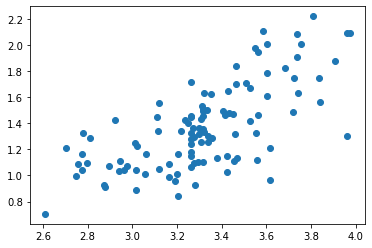

In [32]:
plt.scatter(np.log10(meta.GenerationLength_d), meta["C>G"]/meta["T>A"])

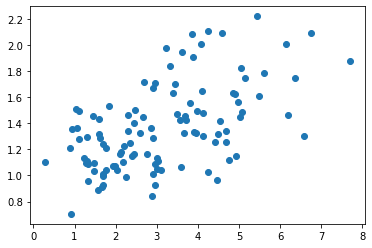

In [28]:
plt.scatter(np.log10(meta.AdultBodyMass_g), meta["C>G"]/meta["T>A"])

In [4]:
sporder = pd.read_csv("All_species-SuperOrders.tab", sep="\t", header=None)
sporder.columns = ["species","order"]

In [5]:
nwkete.prune(list(sporder.species), preserve_branch_length=True)

In [6]:
nwk = toytree.tree(nwkete.write("./../trees/AllSpecies.nwk"), format=1)

In [13]:
colors_dict = {order:next(toytree.icolors2) for i,order in enumerate(sporder.order.unique())}

In [38]:
sporder = sporder[sporder.order!="Glires"]
sptoorder = sporder.set_index("species").to_dict()["order"]

In [39]:
sptoorder["Homo_sapiens"]  = "Euarchonta"
sptoorder["Mus_musculus"] = "Castormyomorpha"
sptoorder["Felis_catus"] = "Ferae"

In [44]:
sptoorder["Ctenodactylus_gundi"] = "Hystricomorpha"

In [46]:
colors = [colors_dict[sptoorder[sp]] for sp in nwk.get_tip_labels()]
canvas, axes, mark = nwk.draw(
    tip_labels_colors=colors,
    tip_labels_align=True,
    height=800,
    tip_labels_style={
        "font-size": "8px",
    }
);
toyplot.pdf.render(canvas, "./../Orders_tree.pdf")

In [273]:
# Read speces with chromosome assemblies
with open("chrom_assemblies.txt") as cfile:
    chrom_assemblies = ["_".join(line.strip().split()) for line in cfile]

### Prepare files for pipeline

In [335]:
def sort_by_phylo_distance(nwk, chrom_assemblies, list_of_species):
    phylo_distances = {}
    for c_assembly in chrom_assemblies:
        phylo_distances[c_assembly] = np.average([nwk.get_distance(c_assembly,sp) for sp in list_of_species if sp!=c_assembly])
    phylo_distances_df = pd.DataFrame([phylo_distances]).transpose().reset_index()
    phylo_distances_df.columns = ["species", "distances"]
    phylo_distances_df = phylo_distances_df.sort_values(by="distances")
    phylo_distances_df.index = range(len(phylo_distances_df))
    return list(phylo_distances_df.species.values)

def superorder_tab(superdf, chrom_assemblies, nwk):
    species_list = list(superdf.Species.values)
    good_assemblies = [sp for sp in superdf.Species if sp in chrom_assemblies]
    #print(species_list, good_assemblies, df.SuperOrder.unique())
    good_assemblies_sorted = sort_by_phylo_distance(nwk, chrom_assemblies, species_list)
    return pd.Series([",".join(good_assemblies_sorted), ",".join(species_list)])

guide_superorders = meta.groupby("SuperOrder").apply(lambda x: superorder_tab(x, chrom_assemblies, nwkete)).reset_index()
guide_superorders.columns = ["superorder", "chrom_assemblies", "species"]

In [350]:
guide_superorders.to_csv("SuperOrders_to_assemblies_complete.tab", sep="\t", index=False)

In [352]:
manual_assemblies = {"Artiodactyla":"Bos_taurus",
                     "Atlantogenata":"Homo_sapiens",
                     "Chiroptera":"Homo_sapiens",
                     "Euarchonta":"Homo_sapiens",
                     "Eulipotyphla":"Homo_sapiens",
                     "Ferae":"Felis_catus",
                     "Glires":"Mus_musculus",
                     "Perissodactyla":"Equus_caballus"
                    }
with open("SuperOrders_to_assemblies.tab","w") as sf:
    sf.write("\n".join(["\t".join([k,v]) for k,v in manual_assemblies.items()]))

In [362]:
for exp,ref in zip(["Control1", "Control2"], ["Homo_sapiens", "Mus_musculus"]):
    print(exp,ref)

Control1 Homo_sapiens
Control2 Mus_musculus


In [361]:
for super_order,df in meta[meta.Sex!="male"].groupby("SuperOrder"):
    print(super_order, len(df))
    with open("../species_list/{}.txt".format(super_order), "w") as sf:
        sf.write(",".join(df.Species) + "\n")

Artiodactyla 26
Atlantogenata 16
Chiroptera 23
Euarchonta 37
Eulipotyphla 7
Ferae 20
Glires 50
Perissodactyla 7
